In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers, models, utils, saving
import librosa
import matplotlib.pyplot as plt
import random
import shutil

2024-12-23 08:56:48.712268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734944208.864531    6577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734944208.906222    6577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 08:56:49.270884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model initialization

In [7]:
@saving.register_keras_serializable()
class AuditoryCortexNet(models.Model):
    def __init__(self, input_shape, num_classes, **kwargs):
        """
        Initialize auditory cortex-inspired neural network
        
        Args:
            input_shape (tuple): Input cochleagram shape (time, frequency, channels)
            num_classes (int): Number of output classes
        """
        super().__init__(**kwargs)
        self.input_shape = input_shape
        self.num_classes = num_classes
        
        # Primary Auditory Cortex (A1) Layers
        self.primary_layers = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2))
        ])
        
        # Belt Regions Layers
        self.belt_layers = models.Sequential([
            layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D()
        ])
        
        # Parabelt Regions (Dense Layers)
        self.parabelt_layers = models.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
    
    def call(self, inputs):
        """
        Forward pass through the network
        
        Args:
            inputs (tensor): Input cochleagram
        
        Returns:
            tensor: Class probabilities
        """
        x = self.primary_layers(inputs)
        x = self.belt_layers(x)
        x = self.parabelt_layers(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_shape": self.input_shape,
            "num_classes": self.num_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [4]:
def create_model(input_shape, num_classes):
    """
    Convenience function to create and compile the model
    
    Args:
        input_shape (tuple): Input cochleagram shape
        num_classes (int): Number of output classes
    
    Returns:
        compiled keras model
    """
    model = AuditoryCortexNet(input_shape, num_classes)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Data handling

In [5]:
def load_cochleagrams(dataset_dir, num_classes):
    """
    Load cochleagrams and their corresponding labels for training
    
    Args:
        dataset_dir (str): Path to cochleagram directory
        num_classes (int): Number of classes (speakers)
    
    Returns:
        tuple: (X, y) where X is the input data and y is the one-hot encoded labels
    """
    X = []
    y = []
    # Exclude background noise and other directories
    valid_labels = [label for label in os.listdir(dataset_dir) 
                    if label not in ['_background_noise_', 'other']]
    
    label_map = {label: idx for idx, label in enumerate(sorted(valid_labels))}
    
    for label in valid_labels:
        label_dir = os.path.join(dataset_dir, label)
        for file in os.listdir(label_dir):
            if file.endswith('.npy'):
                cochleagram = np.load(os.path.join(label_dir, file))
                
                if len(cochleagram.shape) == 2:
                    cochleagram = np.expand_dims(cochleagram, axis=-1)
                
                X.append(cochleagram)
                y.append(label_map[label])
    
    return np.array(X), utils.to_categorical(y, num_classes=num_classes)

def prepare_data(dataset_dir, num_classes, test_size=0.2, val_size=0.2):
    """
    Split data into training, validation, and test sets
    
    Args:
        dataset_dir (str): Path to cochleagram directory
        num_classes (int): Number of classes (speakers)
        test_size (float): Proportion of data for the test set
        val_size (float): Proportion of training data for the validation set
    
    Returns:
        tuple: (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    X, y = load_cochleagrams(dataset_dir, num_classes)
    
    # Split into training+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    
    # Split training+validation into training and validation sets
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split, stratify=y_train_val)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

Main code

In [8]:
dataset_dir = "/home/hridai/code/auditory-cortex/datasets/cochleagrams"
num_classes = 5
(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_data(dataset_dir, num_classes)

# Input shape for the model
input_shape = X_train.shape[1:]  # (time_steps, frequency_bins, channels)

# Create the model
model = create_model(input_shape, num_classes)

# Summary of the model
model.summary()

Model: "auditory_cortex_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 32, 8, 64)      │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,200 (75.00 KB)

 Trainable params: 19,008 (74.25 KB)

 Non-trainable params: 192 (768.00 B)

In [9]:
# Train the model
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/10


I0000 00:00:1734945393.657947    8847 service.cc:148] XLA service 0x7fa0000062e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734945393.658477    8847 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-12-23 09:16:33.794576: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734945394.491006    8847 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-23 09:16:35.530871: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,128,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

  2/141 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.2422 - loss: 2.0789  

I0000 00:00:1734945400.719304    8847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2732 - loss: 1.6080

2024-12-23 09:16:44.209814: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,128,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,1,128,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-23 09:16:44.233367: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,64,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,64,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2739 - loss: 1.6064

2024-12-23 09:16:49.817508: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,128,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-23 09:16:49.826349: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,64,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,64,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.2746 - loss: 1.6047 - val_accuracy: 0.5653 - val_loss: 1.0251
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6033 - loss: 0.8910 - val_accuracy: 0.5800 - val_loss: 0.8788
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6753 - loss: 0.7585 - val_accuracy: 0.7640 - val_loss: 0.6238
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7539 - loss: 0.6147 - val_accuracy: 0.8713 - val_loss: 0.3346
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8428 - loss: 0.4247 - val_accuracy: 0.9320 - val_loss: 0.2001
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8836 - loss: 0.3552 - val_accuracy: 0.9060 - val_loss: 0.3013
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9290 - loss: 0.2111 - val_accuracy: 0.9420 - val_loss: 0.1676
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9442 - loss: 0.1604 - val_accuracy: 0.95

2024-12-23 09:17:22.574836: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[29,32,128,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,1,128,32]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-23 09:17:22.599720: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[29,64,64,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,32,64,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9315 - loss: 0.1872
Test Accuracy: 0.93


In [10]:
# Save the model to a directory
model_save_path = "/home/hridai/code/auditory-cortex/auditory_CNN_traditional.keras"
model.save(model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at /home/hridai/code/auditory-cortex/auditory_CNN_traditional.keras


Analysis

In [23]:
def get_feature_maps(model, input_sample, layer_names):
    intermediate_models = {name: models.Model(inputs=model.input, outputs=model.get_layer(name).output)
                           for name in layer_names}

    feature_maps = {}

    for name, intermediate_model in intermediate_models.items():
        feature_map = intermediate_model.predict(input_sample)

        # Store the feature maps in a dictionary
        feature_maps[name] = feature_map

    return feature_maps

def plot_feature_maps(feature_maps, num_filters=16):
    for name, feature_map in feature_maps.items():
        print(f"Feature map shape for layer {name}: {feature_map.shape}")

        # Only plot if the feature map has spatial dimensions (4D)
        if len(feature_map.shape) == 4:  
            num_filters = min(num_filters, feature_map.shape[-1])
            size = feature_map.shape[1:3]  # Spatial dimensions

            plt.figure(figsize=(15, 15))
            for i in range(num_filters):
                plt.subplot(4, 4, i + 1)
                plt.imshow(feature_map[0, :, :, i], cmap='viridis')
                plt.axis('off')
            plt.suptitle(f"Feature Maps from Layer: {name} (Shape: {size})", fontsize=16)
            plt.show()
        else:
            print(f"Skipping plotting for layer {name} as the output is not a 4D feature map.")

def saliency_map(model, input_sample, class_index):
    """Compute the saliency map for a specific class prediction."""
    input_sample = tf.convert_to_tensor(input_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_sample)
        predictions = model(input_sample)
        loss = predictions[0, class_index]
    grads = tape.gradient(loss, input_sample)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]
    return saliency

def plot_cochleagram(cochleagram, title="Cochleagram"):
    cochleagram = np.squeeze(cochleagram)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(cochleagram, sr=16000, hop_length=512, 
                             x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


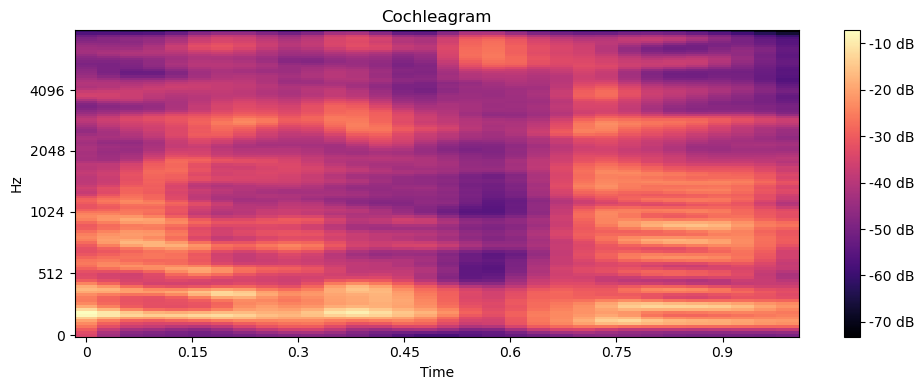

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


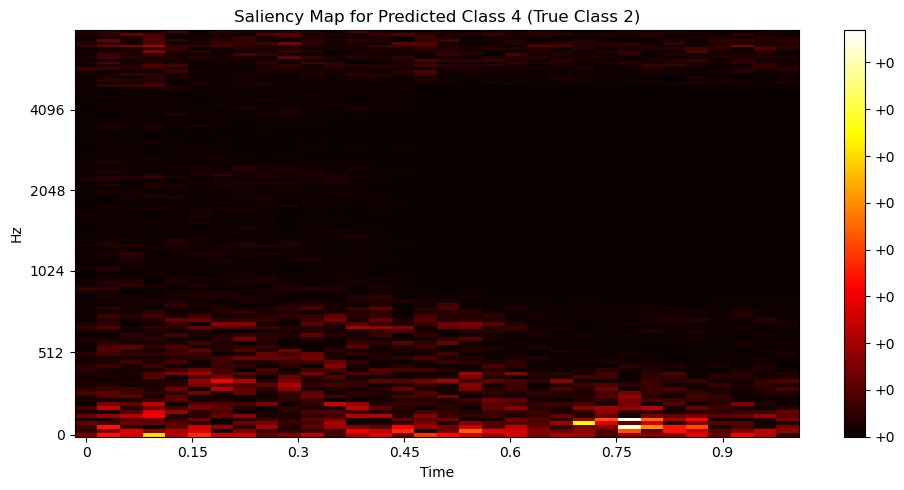

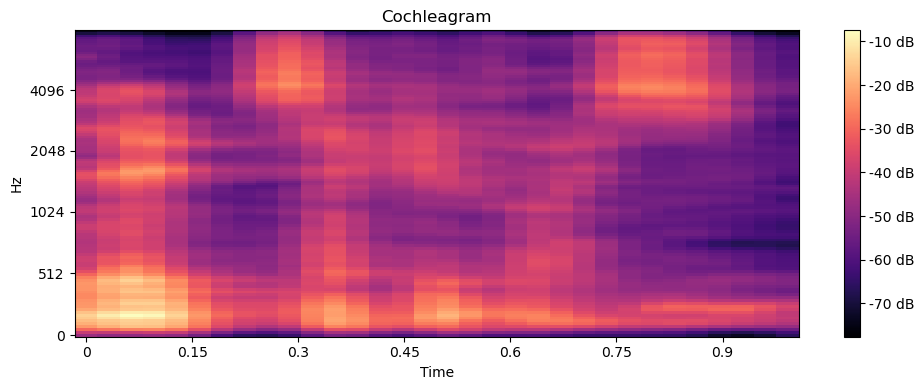

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


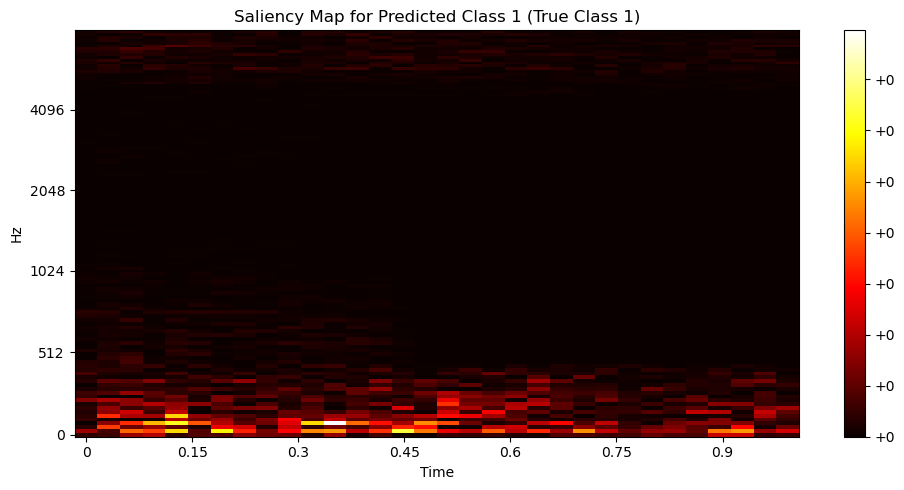

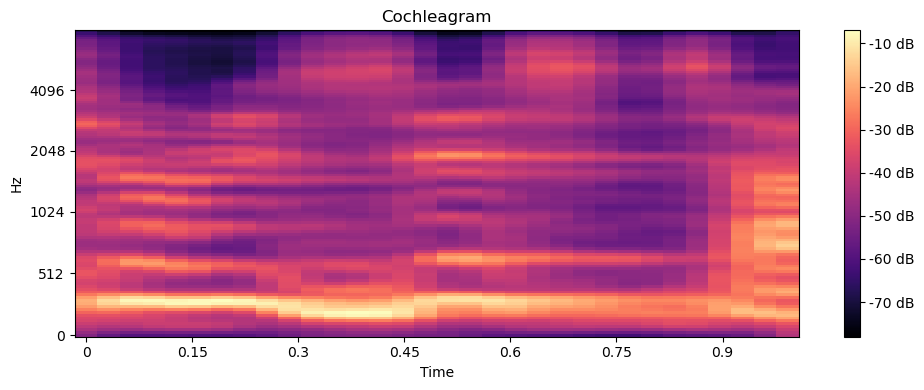

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


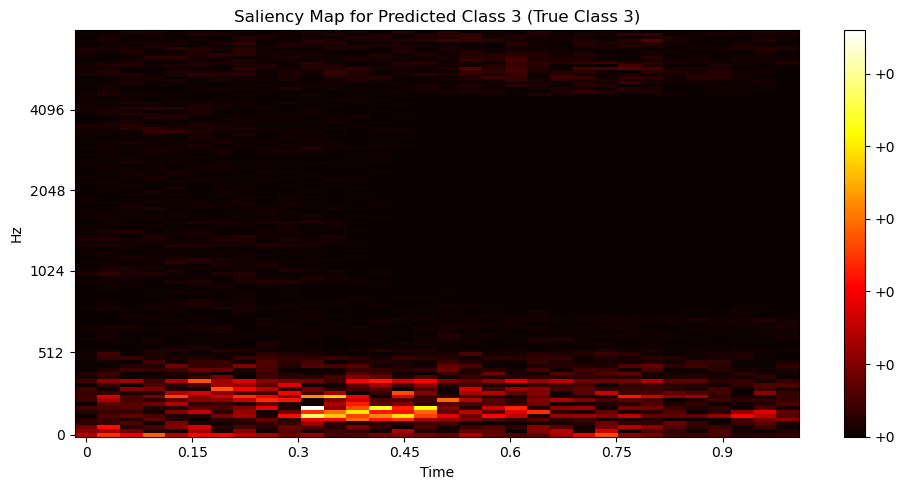

In [27]:

for i in range(3):
    # Prepare input sample
    sample_index = i
    input_sample = X_test[sample_index]

    plot_cochleagram(input_sample)

    input_sample = input_sample.reshape((1,) + input_shape)
    true_label = np.argmax(y_test[sample_index])



    # Define the layers to probe for feature and saliency maps
    layer_names = [layer.name for layer in model.layers if isinstance(layer, (layers.Conv2D, layers.BatchNormalization))]


    # Visualize Saliency Map
    predicted_class = np.argmax(model.predict(input_sample))
    saliency = saliency_map(model, input_sample, predicted_class)

    plt.figure(figsize=(10, 5))
    librosa.display.specshow(saliency, x_axis='time', y_axis='mel', cmap='hot', sr=16000)
    plt.colorbar(format='%+2.0f')
    plt.title(f"Saliency Map for Predicted Class {predicted_class} (True Class {true_label})")
    plt.tight_layout()
    plt.show()

In [40]:
idx = 0
in_sample = X_test[idx]

in_sample.shape

(128, 32, 1)

Checking for feature selectivity

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
import seaborn as sns

def generate_neurophysiological_patterns():
    """
    Generate test patterns based on known auditory cortex stimulus preferences
    """
    time_steps, freq_bins = 128, 32
    patterns = {}
    
    # 1. Frequency Modulated (FM) sweeps at different speeds
    speeds = [0.5, 1, 2, 4]  # Different sweep speeds
    for speed in speeds:
        sweep_up = np.zeros((time_steps, freq_bins, 1))
        sweep_down = np.zeros((time_steps, freq_bins, 1))
        for t in range(time_steps):
            freq_idx = int((t * speed) % (freq_bins - 1))
            sweep_up[t, freq_idx, 0] = 1
            sweep_down[t, freq_bins - 1 - freq_idx, 0] = 1
        patterns[f'fm_sweep_up_{speed}x'] = sweep_up
        patterns[f'fm_sweep_down_{speed}x'] = sweep_down
    
    # 2. Spectral bandwidth patterns
    for bandwidth in [1, 2, 4, 8]:  # Different bandwidths in bins
        band = np.zeros((time_steps, freq_bins, 1))
        center = freq_bins // 2
        half_width = bandwidth // 2
        band[:, max(0, center-half_width):min(freq_bins, center+half_width), 0] = 1
        patterns[f'bandwidth_{bandwidth}'] = band
    
    # 3. Temporal modulation patterns
    for rate in [2, 4, 8, 16]:  # Hz
        am = np.zeros((time_steps, freq_bins, 1))
        t = np.linspace(0, 2*np.pi, time_steps)
        modulation = (np.sin(rate * t) + 1) / 2
        for f in range(0, freq_bins, 4):
            am[:, f, 0] = modulation
        patterns[f'am_{rate}hz'] = am
    
    # 4. Complex spectrotemporal patterns
    temporal_freq = 4  # Hz
    spectral_freq = 2  # cycles per octave
    t = np.linspace(0, 2*np.pi, time_steps)
    f = np.linspace(0, 2*np.pi, freq_bins)
    T, F = np.meshgrid(t, f)
    ripple = np.sin(temporal_freq * T + spectral_freq * F)
    patterns['ripple'] = ripple.T[..., np.newaxis]
    
    # 5. Natural sound inspired patterns
    harmonics = np.zeros((time_steps, freq_bins, 1))
    fundamental = 2  # fundamental frequency bin
    for h in range(1, 6):
        if fundamental * h < freq_bins:
            harmonics[:, fundamental * h, 0] = 1 / h  # Decreasing amplitude
    patterns['harmonics'] = harmonics
    
    # 6. Click trains at different rates
    for rate in [2, 4, 8]:
        clicks = np.zeros((time_steps, freq_bins, 1))
        interval = time_steps // rate
        for t in range(0, time_steps, interval):
            clicks[t:t+2, :, 0] = 1
        patterns[f'clicks_{rate}hz'] = clicks
    
    # 7. Pure Tone at a specific frequency (e.g., 1000 Hz)
    pure_tone = np.zeros((time_steps, freq_bins, 1))
    tone_freq = 1000  # Hz
    tone_bin = int((tone_freq / (16000 / 2)) * freq_bins)  # Map frequency to bin
    pure_tone[:, tone_bin, 0] = 1  # Activate the corresponding frequency bin
    patterns['pure_tone_1000hz'] = pure_tone
    
    # 8. Sine wave modulation across all frequency bins
    sine_wave = np.zeros((time_steps, freq_bins, 1))
    sine_modulation = np.sin(2 * np.pi * 2 * np.linspace(0, 1, time_steps))  # 2 Hz sine modulation
    for f in range(freq_bins):
        sine_wave[:, f, 0] = sine_modulation
    patterns['sine_wave_modulation'] = sine_wave
    
    # 9. White noise
    noise = np.random.randn(time_steps, freq_bins, 1)  # Gaussian noise
    patterns['white_noise'] = noise
    
    return patterns

def analyze_filter_responses(model, pattern_dict, layer_name):
    """
    Analyze how filters respond to different patterns
    """
    sample_pattern = list(pattern_dict.values())[0]
    inputs = tf.keras.layers.Input(shape=sample_pattern.shape)
    
    # Build the model properly through all layers
    x = inputs
    if 'primary' in layer_name:
        x = model.primary_layers(x)
    elif 'belt' in layer_name:
        x = model.primary_layers(x)
        x = model.belt_layers(x)
    
    layer_model = Model(inputs=inputs, outputs=x)
    
    results = {}
    for pattern_name, pattern in pattern_dict.items():
        response = layer_model.predict(pattern[np.newaxis, ...])
        results[pattern_name] = response[0]
    
    return results

def visualize_spectrotemporal_responses(pattern_dict, response_dict, num_filters=4, sampling_rate=16000):
    """
    Visualize responses with correct axis orientation and labels, plotting time from 0 to 1 second 
    and frequency in Hz.
    """
    num_patterns = len(pattern_dict)
    time_steps = next(iter(pattern_dict.values())).shape[0]  # Get number of time steps (128)
    freq_bins = next(iter(pattern_dict.values())).shape[1]  # Get number of frequency bins (32)
    
    # Create time axis in seconds
    time_axis = np.linspace(0, 1, time_steps)
    
    # Create frequency axis in Hz
    freq_axis = np.linspace(0, sampling_rate / 2, freq_bins)  # assuming Nyquist limit for frequency
    
    fig, axes = plt.subplots(num_patterns, num_filters + 1, figsize=(20, 4*num_patterns))
    
    for i, (pattern_name, pattern) in enumerate(pattern_dict.items()):
        # Plot input pattern - transpose for correct orientation
        im = axes[i, 0].imshow(pattern[..., 0].T, aspect='auto', origin='lower', extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])
        axes[i, 0].set_title(f'Input: {pattern_name}')
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Frequency (Hz)')
        
        # Add colorbar for input
        plt.colorbar(im, ax=axes[i, 0])
        
        # Plot filter responses
        response = response_dict[pattern_name]
        for j in range(min(num_filters, response.shape[-1])):
            im = axes[i, j+1].imshow(response[..., j].T, aspect='auto', origin='lower', extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]])
            axes[i, j+1].set_title(f'Filter {j+1} Response')
            axes[i, j+1].set_xlabel('Time (s)')
            plt.colorbar(im, ax=axes[i, j+1])
    
    plt.tight_layout()
    plt.show()

def analyze_neurophysiological_properties(response_dict):
    """
    Analyze response properties relevant to auditory neuroscience
    """
    properties = {}
    
    # 1. Direction selectivity (for FM sweeps)
    up_responses = np.mean([resp for name, resp in response_dict.items() if 'sweep_up' in name])
    down_responses = np.mean([resp for name, resp in response_dict.items() if 'sweep_down' in name])
    properties['direction_selectivity'] = (up_responses - down_responses) / (up_responses + down_responses)
    
    # 2. Temporal modulation transfer function
    tmtf = {}
    for name, resp in response_dict.items():
        if 'am_' in name:
            rate = int(name.split('_')[1][:-2])  # Extract rate number
            tmtf[rate] = np.mean(resp)
    properties['tmtf'] = tmtf
    
    # 3. Bandwidth selectivity
    bandwidth_tuning = {}
    for name, resp in response_dict.items():
        if 'bandwidth_' in name:
            width = int(name.split('_')[1])
            bandwidth_tuning[width] = np.mean(resp)
    properties['bandwidth_tuning'] = bandwidth_tuning
    
    return properties

def plot_neurophysiological_properties(properties):
    """
    Visualize neurophysiological response properties
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Direction selectivity
    axes[0].bar(['Direction\nSelectivity'], [properties['direction_selectivity']])
    axes[0].set_title('FM Sweep Direction Selectivity')
    axes[0].set_ylabel('Selectivity Index')
    
    # 2. Temporal modulation transfer function
    rates = sorted(properties['tmtf'].keys())
    responses = [properties['tmtf'][r] for r in rates]
    axes[1].plot(rates, responses, 'o-')
    axes[1].set_title('Temporal Modulation Transfer Function')
    axes[1].set_xlabel('Modulation Rate (Hz)')
    axes[1].set_ylabel('Response Strength')
    
    # 3. Bandwidth tuning
    widths = sorted(properties['bandwidth_tuning'].keys())
    responses = [properties['bandwidth_tuning'][w] for w in widths]
    axes[2].plot(widths, responses, 'o-')
    axes[2].set_title('Spectral Bandwidth Tuning')
    axes[2].set_xlabel('Bandwidth (bins)')
    axes[2].set_ylabel('Response Strength')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


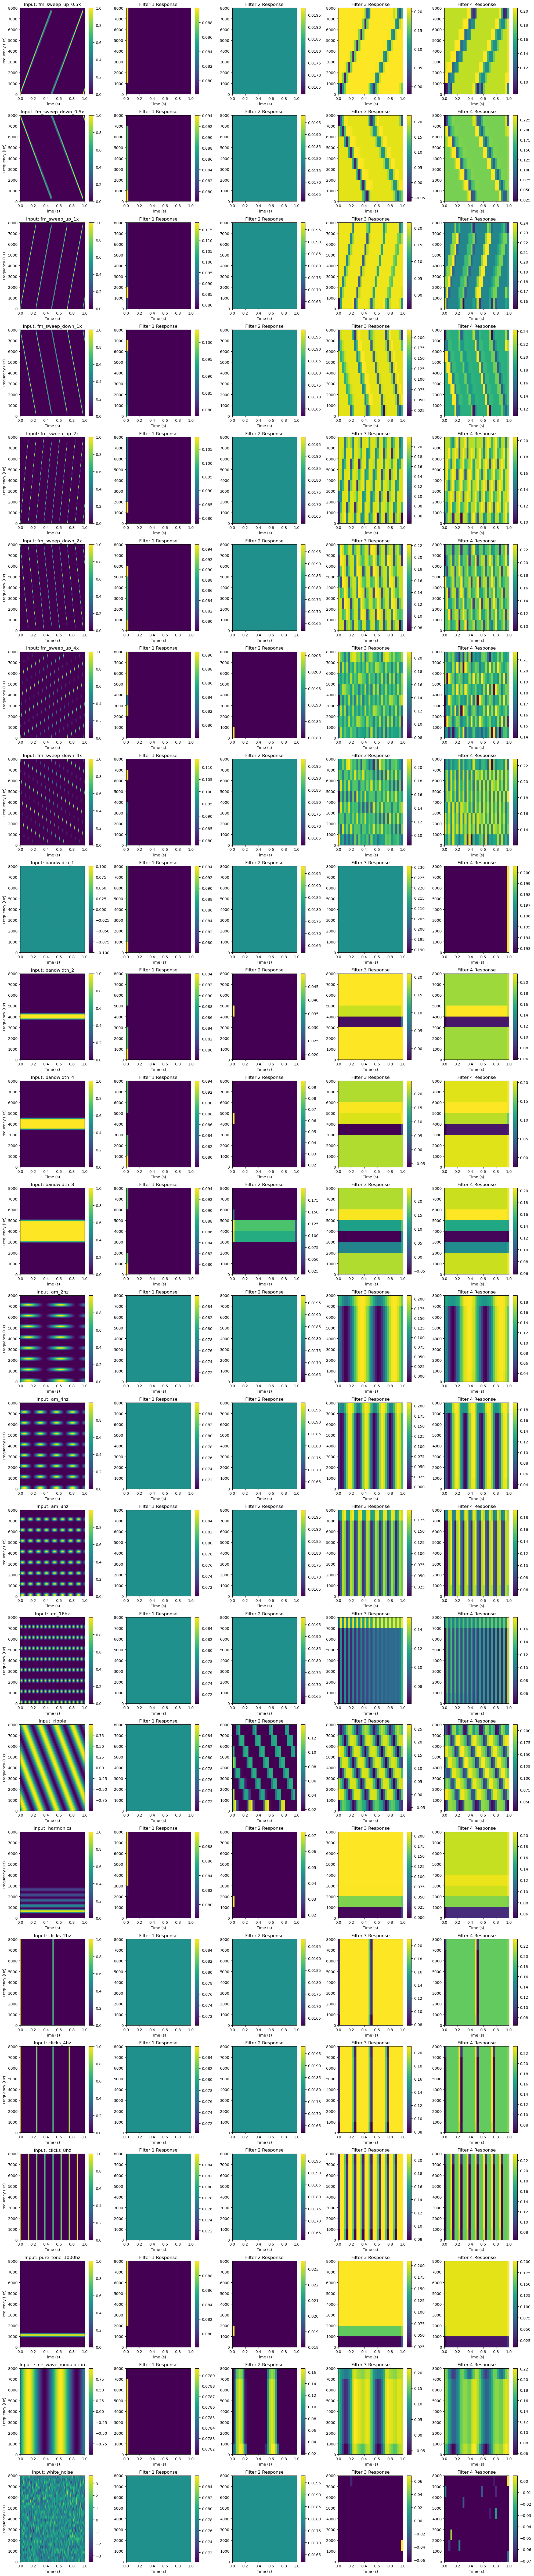

In [101]:
# Generate neurophysiological test patterns
patterns = generate_neurophysiological_patterns()

primary_responses = analyze_filter_responses(model, patterns, 'primary_conv_0')



visualize_spectrotemporal_responses(patterns, primary_responses)

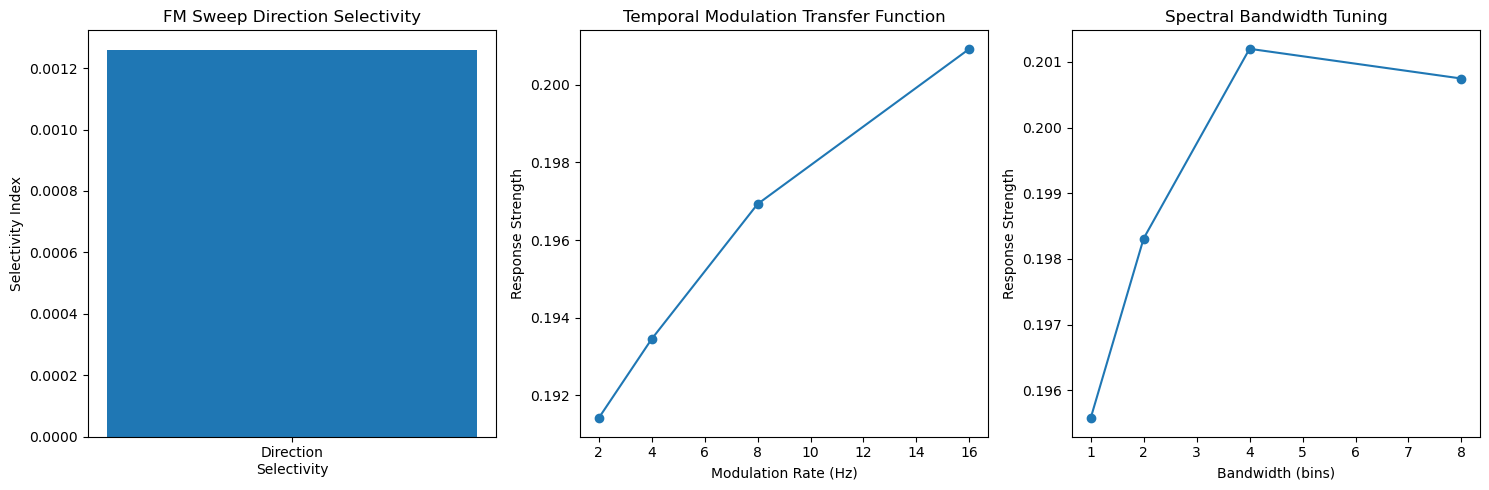

In [102]:
primary_properties = analyze_neurophysiological_properties(primary_responses)
plot_neurophysiological_properties(primary_properties)
